# 최종 제출

In [34]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# scipy
from scipy.stats import boxcox, yeojohnson
from scipy.special import inv_boxcox

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import *

import xgboost as xgb 
import itertools

# 불필요한 경고 메시지를 나오지 않도록 한다.
import warnings
warnings.filterwarnings('ignore')

# 절기 구분을 위한 모듈
import datetime
dateformat = '%Y-%m-%d'

In [35]:
BASE_DIR = './data'

In [36]:
train_path = os.path.join(BASE_DIR, '2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210902_update.xlsx')

data = pd.read_excel(train_path)
data = data[1 : ]
data = data.reset_index(drop = True)
data.iloc[:,6:] = data.iloc[:,6:].apply(pd.to_numeric)  # 수치형으로 변환

data.columns = ['홍수사상번호', '연', '월', '일', '시간', '유입량', 
                '1_유역평균강수', '1_강우(A지역)', '1_강우(B지역)', '1_강우(C지역)', '1_강우(D지역)', '1_수위(E지역)', '1_수위(D지역)', 
                '2_유역평균강수', '2_강우(A지역)', '2_강우(B지역)', '2_강우(C지역)', '2_강우(D지역)', '2_수위(E지역)', '2_수위(D지역)', 
                '3_유역평균강수', '3_강우(A지역)', '3_강우(B지역)', '3_강우(C지역)', '3_강우(D지역)', '3_수위(E지역)', '3_수위(D지역)',
                '4_유역평균강수', '4_강우(A지역)', '4_강우(B지역)', '4_강우(C지역)', '4_강우(D지역)', '4_수위(E지역)', '4_수위(D지역)',
                '5_유역평균강수', '5_강우(A지역)', '5_강우(B지역)', '5_강우(C지역)', '5_강우(D지역)', '5_수위(E지역)', '5_수위(D지역)',
                '6_유역평균강수', '6_강우(A지역)', '6_강우(B지역)', '6_강우(C지역)', '6_강우(D지역)', '6_수위(E지역)', '6_수위(D지역)']

In [37]:
submit_path = os.path.join(BASE_DIR, '2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_평가데이터_210803.xlsx')

submit = pd.read_excel(submit_path, header = 0)

submit = submit[1 :]
submit = submit.reset_index(drop = True)


submit.head()

,홍수사상번호,연,월,일,시간,유입량
0,26.0,2018.0,7.0,1.0,6.0,NaN
1,26.0,2018.0,7.0,1.0,7.0,NaN
2,26.0,2018.0,7.0,1.0,8.0,NaN
3,26.0,2018.0,7.0,1.0,9.0,NaN
4,26.0,2018.0,7.0,1.0,10.0,NaN


In [38]:
weather_path = os.path.join(BASE_DIR, '기상데이터.csv')

weather_data = pd.read_csv(weather_path, encoding = 'euc-kr')
print('기상데이터 적용 전 :', data.shape)
data = pd.merge(data, weather_data,left_index=True, right_index=True, how='left')

print('기상데이터 적용 후 :', data.shape)

기상데이터 적용 전 : (3051, 48)
기상데이터 적용 후 : (3051, 52)


In [39]:
data_feat = data.copy()

In [40]:
data_7 = data_feat[['1_유역평균강수', '2_유역평균강수', '3_유역평균강수', '4_유역평균강수', '5_유역평균강수', '6_유역평균강수']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.DataFrame(lst_mean, columns = ['7_유역평균강수'])

data_7 = data_feat[['1_강우(A지역)', '2_강우(A지역)', '3_강우(A지역)', '4_강우(A지역)', '5_강우(A지역)', '6_강우(A지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(A지역)'])], axis = 1)

data_7 = data_feat[['1_강우(B지역)', '2_강우(B지역)', '3_강우(B지역)', '4_강우(B지역)', '5_강우(B지역)', '6_강우(B지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(B지역)'])], axis = 1)

data_7 = data_feat[['1_강우(C지역)', '2_강우(C지역)', '3_강우(C지역)', '4_강우(C지역)', '5_강우(C지역)', '6_강우(C지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(C지역)'])], axis = 1)

data_7 = data_feat[['1_강우(D지역)', '2_강우(D지역)', '3_강우(D지역)', '4_강우(D지역)', '5_강우(D지역)', '6_강우(D지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(D지역)'])], axis = 1)

data_7 = data_feat[['1_수위(D지역)', '2_수위(D지역)', '3_수위(D지역)', '4_수위(D지역)', '5_수위(D지역)', '6_수위(D지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_수위(D지역)'])], axis = 1)
data_feat = pd.concat([data_feat, data_feat_7], axis = 1)

In [41]:
# rolling 1
data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_1'] = data_feat['7_유역평균강수'].shift(1)
data_rolling['7_강우(A지역)_shift_1'] = data_feat['7_강우(A지역)'].shift(1)
data_rolling['7_강우(B지역)_shift_1'] = data_feat['7_강우(B지역)'].shift(1)
data_rolling['7_강우(C지역)_shift_1'] = data_feat['7_강우(C지역)'].shift(1)
data_rolling['7_강우(D지역)_shift_1'] = data_feat['7_강우(D지역)'].shift(1)
data_rolling['7_수위(D지역)_shift_1'] = data_feat['7_수위(D지역)'].shift(1)
data_rolling['7_수위(E지역)_shift_1'] = data_feat['1_수위(E지역)'].shift(1)
for i in range(1, 27) :
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_1'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)

data_feat = pd.concat([data_feat, data_rolling], axis = 1)

In [42]:
# rolling 2
data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_2'] = data_feat['7_유역평균강수_shift_1'].shift(1)
data_rolling['7_강우(A지역)_shift_2'] = data_feat['7_강우(A지역)_shift_1'].shift(1)
data_rolling['7_강우(B지역)_shift_2'] = data_feat['7_강우(B지역)_shift_1'].shift(1)
data_rolling['7_강우(C지역)_shift_2'] = data_feat['7_강우(C지역)_shift_1'].shift(1)
data_rolling['7_강우(D지역)_shift_2'] = data_feat['7_강우(D지역)_shift_1'].shift(1)
data_rolling['7_수위(D지역)_shift_2'] = data_feat['7_수위(D지역)_shift_1'].shift(1)
data_rolling['7_수위(E지역)_shift_2'] = data_feat['7_수위(E지역)_shift_1'].shift(1)
for i in range(1, 27) :
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_2'] = dx
        
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_2'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)
data_feat = pd.concat([data_feat, data_rolling], axis = 1)

In [43]:
# rolling 3
data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_3'] = data_feat['7_유역평균강수_shift_2'].shift(1)
data_rolling['7_강우(A지역)_shift_3'] = data_feat['7_강우(A지역)_shift_2'].shift(1)
data_rolling['7_강우(B지역)_shift_3'] = data_feat['7_강우(B지역)_shift_2'].shift(1)
data_rolling['7_강우(C지역)_shift_3'] = data_feat['7_강우(C지역)_shift_2'].shift(1)
data_rolling['7_강우(D지역)_shift_3'] = data_feat['7_강우(D지역)_shift_2'].shift(1)
data_rolling['7_수위(D지역)_shift_3'] = data_feat['7_수위(D지역)_shift_2'].shift(1)
data_rolling['7_수위(E지역)_shift_3'] = data_feat['7_수위(E지역)_shift_2'].shift(1)
for i in range(1, 27) :
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_3'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)
data_feat = pd.concat([data_feat, data_rolling], axis = 1)

In [44]:
data_feat['7_유역평균강수_diff'] = pd.DataFrame(data_feat['7_유역평균강수'] - data_feat['7_유역평균강수_shift_1'])
data_feat['7_강우(A지역)_diff'] = pd.DataFrame(data_feat['7_강우(A지역)'] - data_feat['7_강우(A지역)_shift_1'])
data_feat['7_강우(B지역)_diff'] = pd.DataFrame(data_feat['7_강우(B지역)'] - data_feat['7_강우(B지역)_shift_1'])
data_feat['7_강우(C지역)_diff'] = pd.DataFrame(data_feat['7_강우(C지역)'] - data_feat['7_강우(C지역)_shift_1'])
data_feat['7_강우(D지역)_diff'] = pd.DataFrame(data_feat['7_강우(D지역)'] - data_feat['7_강우(D지역)_shift_1'])
data_feat['7_수위(D지역)_diff'] = pd.DataFrame(data_feat['7_수위(D지역)'] - data_feat['7_수위(D지역)_shift_1'])
data_feat['7_수위(E지역)_diff'] = pd.DataFrame(data_feat['1_수위(E지역)'] - data_feat['7_수위(E지역)_shift_1'])

In [45]:
rain = data_feat.groupby('홍수사상번호')['시간'].count()
lst = np.array(rain.tolist())

flood = []
for i in range(26):
    x = list(range(1, lst[i]+1))
    flood.extend(x)

flood = pd.DataFrame(flood)
flood.columns = ['홍수기간']
data_feat = pd.concat([data_feat, flood], axis = 1)

data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),...,7_수위(D지역)_shift_3,7_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff,홍수기간
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,...,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,...,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,...,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,...,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,...,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,...,129.925417,3.21,0.000000,0.0,0.0,-0.25,0.00,0.011875,-0.02,156
3047,26.0,2018.0,7.0,7.0,18.0,NaN,2.3689,1,0,0,...,129.939375,3.19,0.000000,0.0,0.0,0.00,0.00,0.013208,-0.01,157
3048,26.0,2018.0,7.0,7.0,19.0,NaN,2.3689,1,0,0,...,129.957229,3.18,0.000000,0.0,0.0,0.00,0.00,0.007062,-0.02,158
3049,26.0,2018.0,7.0,7.0,20.0,NaN,2.3689,1,0,0,...,129.969104,3.16,-0.005025,0.0,0.0,0.00,0.00,0.007063,-0.02,159


In [46]:
bins = [0,30, 50, 70, 100, 120, 160, 220] 
data_feat['홍수_bin'] = np.digitize(data_feat['홍수기간'], bins)
data_feat.groupby('홍수_bin')[['홍수기간']].count()

,홍수기간
홍수_bin,
1,754
2,494
3,416
4,480
5,196
6,263
7,287
8,161


In [47]:
# kmeans를 하기위해서는 변수들이 수치형데이터여야 한다. 그리고 타겟변수인 유입량도 빼준다.
# 그리고 시간의 영향을 제거해보기 위해 시간관련 열들도 제거해본다
data_feat_target = data_feat[data_feat['홍수사상번호'] > 25]
data_feat = data_feat[data_feat['홍수사상번호'] < 26]
data_feat_kmeans = data_feat.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '유입량'], axis = 1)
data_feat_target_kmeans = data_feat_target.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '유입량'], axis = 1)

In [48]:
# create model and prediction
scaler = StandardScaler()
model = KMeans(n_clusters=2,algorithm='auto')
pipeline = make_pipeline(scaler,model)
pipeline.fit(data_feat_kmeans)

predict_target = pd.DataFrame(pipeline.predict(data_feat_target_kmeans))
predict_target.columns=['kmeans']
predict = pd.DataFrame(pipeline.predict(data_feat_kmeans))
predict.columns=['kmeans']

In [49]:
# 인덱스 초기화 해서 합치고 다시 기존 인덱스 사용
data_feat = pd.concat([pd.concat([data_feat, predict], axis = 1), pd.concat([data_feat_target.reset_index(), predict_target], axis = 1).set_index('index')])

In [50]:
data_time = data_feat[['연', '월', '일', '시간']]

data_time['연'] = [str(int(i)) for i in data_time['연']]
data_time['월'] = [str(int(i)) for i in data_time['월']]
data_time['일'] = [str(int(i)) for i in data_time['일']]
data_time['시간'] = [str(int(i)) for i in data_time['시간']]

# 7월 8일 기준으로 일 차이를 열로 만든다 (소서)
data_time['월일'] = data_time['월'] + '-' + data_time['일']
data_time['월일'] = [datetime.datetime.strptime(i, '%m-%d')  for i in data_time['월일']]
data_time['월일'] = data_time['월일'] - datetime.datetime.strptime('7-8', '%m-%d')
data_time['월일'] = [i.days for i in data_time['월일']]
data_time['절기'] = data_time['월일']
data_time['절기'] = [i // 15 for i in data_time['절기']]

# 6/28 부터 9/24일 까지 시작일 포함 총 89일.
for i in range(len(data_time)) :
    if data_time['절기'].iloc[i] < 0 :
        data_time.loc[i, '절기'] = '하지'
    elif data_time['절기'].iloc[i] == 0 :
        data_time.loc[i, '절기'] = '소서'
    elif data_time['절기'].iloc[i] == 1 :
        data_time.loc[i, '절기'] = '대서'
    elif data_time['절기'].iloc[i] == 2 :
        data_time.loc[i, '절기'] = '입추'
    elif data_time['절기'].iloc[i] == 3 :
        data_time.loc[i, '절기'] = '처서'
    elif data_time['절기'].iloc[i] == 4 :
        data_time.loc[i, '절기'] = '백로'
    else :
        data_time.loc[i, '절기'] = '추분'
    
data_time = data_time[['절기']]
data_feat = pd.concat([data_feat, data_time], axis = 1)

In [51]:
data_feat['홍수사상번호'] = data_feat['홍수사상번호'].astype('object')

In [52]:
py_data = data_feat.copy()
py_data['홍수사상번호'] = py_data['홍수사상번호'].astype('object')
py_data = py_data[py_data['홍수사상번호'] != 1]
py_data = py_data.reset_index(drop = True)
temp_list = py_data.절기.unique().tolist()
py_data['절기'] = py_data.절기.map(lambda x : temp_list.index(x))
py_data['절기'] = py_data['절기'].astype('float')
py_data['kmeans'] = py_data['kmeans'].astype('float')
py_data['홍수_bin'] = py_data['홍수_bin'].astype('float')
py_data = py_data.drop(['일시', '연', '월', '일', '시간'], axis = 1)

In [53]:
py_data

,홍수사상번호,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,...,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff,홍수기간,홍수_bin,kmeans,절기
0,2.0,323.993267,0.0000,0,1,0,0,2.93,134.44375,0.0000,...,0.0,1.0,0.50,0.00,-0.017604,-0.02,1,1.0,1.0,0.0
1,2.0,323.154138,0.0000,0,2,0,0,2.91,134.42500,0.5000,...,0.5,1.0,0.50,0.50,-0.017604,-0.02,2,1.0,1.0,0.0
2,2.0,293.240313,0.5000,0,2,0,0,2.90,134.40000,1.5000,...,1.0,0.0,0.75,0.50,-0.022500,-0.01,3,1.0,1.0,0.0
3,2.0,261.177678,1.5000,0,3,0,0,2.89,134.38125,2.6000,...,2.5,1.0,1.00,0.75,-0.020937,-0.01,4,1.0,1.0,0.0
4,2.0,256.388403,2.6000,1,4,1,1,2.88,134.36250,4.0000,...,4.5,1.0,0.50,1.00,-0.019937,-0.01,5,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,26.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,...,0.0,0.0,-0.25,0.00,0.011875,-0.02,156,6.0,1.0,5.0
2821,26.0,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,...,0.0,0.0,0.00,0.00,0.013208,-0.01,157,6.0,1.0,5.0
2822,26.0,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,...,0.0,0.0,0.00,0.00,0.007062,-0.02,158,6.0,1.0,5.0
2823,26.0,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,...,0.0,0.0,0.00,0.00,0.007063,-0.02,159,6.0,1.0,5.0


In [54]:
train = py_data[py_data['홍수사상번호'] != 26]
target = py_data[py_data['홍수사상번호'] == 26].reset_index(drop = True)
y_target = py_data[py_data['홍수사상번호'] == 26][['유입량']].reset_index(drop = True)
y_train = py_data[py_data['홍수사상번호'] != 26][['유입량']]

In [55]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

cat_columns = [c for c, t in zip(train.dtypes.index, train.dtypes) if t=='O'] 
scale_cols = [c for c in train.drop(['유입량'], axis = 1).columns if c not in cat_columns]

# train 정규화 수행
scaled_df = scaler.fit_transform(train[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
train = train.drop(scaled_df.columns, axis = 1)

scaled_train = pd.concat([train.drop(['유입량'], axis = 1), scaled_df, y_train], axis = 1)


cat_columns = [c for c, t in zip(target.dtypes.index, target.dtypes) if t=='O'] 
scale_cols = [c for c in target.drop(['유입량'], axis = 1).columns if c not in cat_columns]

# target 정규화 수행
scaled_df = scaler.transform(target[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
target = target.drop(scaled_df.columns, axis = 1)

scaled_target = pd.concat([target.drop(['유입량'], axis = 1), scaled_df, y_target], axis = 1)

In [56]:
scaled_target

,홍수사상번호,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),...,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff,홍수기간,홍수_bin,kmeans,절기,유입량
0,26.0,-0.931066,-0.603097,-1.072414,-0.899770,-0.923587,-1.122462,-1.934572,-1.005856,-0.638570,...,-0.106149,0.065317,-0.096329,-0.477750,-0.080485,-1.162192,-1.096760,0.642685,1.38384,NaN
1,26.0,-0.995817,-0.775801,-1.053776,-0.899770,-0.923587,-1.122462,-1.935638,-1.065277,-0.809060,...,0.135635,1.922889,0.805621,-0.477750,-0.080485,-1.147116,-1.096760,0.642685,1.38384,NaN
2,26.0,-1.055250,-0.905329,-0.979226,-0.899770,-0.923587,-1.127143,-1.936703,-1.066312,-0.922720,...,0.860988,0.761907,1.707570,-0.477750,-0.125585,-1.132039,-1.096760,0.642685,1.38384,NaN
3,26.0,-1.056285,-1.020465,-0.867400,-0.899770,-0.923587,-1.127143,-1.937769,-0.958998,-0.908512,...,1.344557,1.458496,1.369339,-0.477750,-0.080485,-1.116963,-1.096760,0.642685,1.38384,NaN
4,26.0,-0.948950,-1.006073,-0.606474,-0.875583,-0.775602,-1.127143,-1.937769,-0.826693,-0.837475,...,3.278832,1.458496,1.594827,-0.426021,-0.080485,-1.101887,-1.096760,0.642685,1.38384,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,26.0,-1.164916,-1.049249,-1.072414,-0.899770,-0.923587,-0.546642,-0.314857,-1.174922,-1.079002,...,-0.106149,-0.166879,-0.096329,-0.255166,-0.170684,1.174643,1.172898,0.642685,1.38384,NaN
156,26.0,-1.164916,-1.049249,-1.072414,-0.899770,-0.923587,-0.551323,-0.312726,-1.174922,-1.079002,...,-0.106149,-0.089481,-0.096329,-0.236248,-0.125585,1.189720,1.172898,0.642685,1.38384,NaN
157,26.0,-1.164916,-1.049249,-1.072414,-0.899770,-0.923587,-0.560686,-0.311660,-1.174922,-1.079002,...,-0.106149,-0.089481,-0.096329,-0.323449,-0.170684,1.204796,1.172898,0.642685,1.38384,NaN
158,26.0,-1.164916,-1.049249,-1.072414,-0.899770,-0.923587,-0.570049,-0.310595,-1.174922,-1.079002,...,-0.106149,-0.089481,-0.096329,-0.323449,-0.170684,1.219873,1.172898,0.642685,1.38384,NaN


In [57]:
model = xgb.XGBRegressor(colsample_bytree = 0.99,
                         gamma = 0.0,
                         learning_rate = 0.05,
                         max_depth = 10,
                         min_child_weight = 0.9215786233997231,
                         n_estimators = 6038,
                         reg_alpha = 0.36516267277203135,
                         reg_lambda = 0.01,
                         subsample = 0.7611671326691636)

In [58]:
target_y = scaled_target[['유입량']]
train_y = scaled_train[['유입량']]

box_result = boxcox(train_y['유입량'])
train_y['유입량'] = boxcox(train_y['유입량'])[0]

target = scaled_target.drop(['홍수사상번호', '유입량'], axis = 1)
train = scaled_train.drop(['홍수사상번호', '유입량'], axis = 1)

In [59]:
model.fit(train, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.99, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=0.9215786233997231, missing=nan,
             monotone_constraints='()', n_estimators=6038, n_jobs=12,
             num_parallel_tree=1, random_state=0, reg_alpha=0.36516267277203135,
             reg_lambda=0.01, scale_pos_weight=1, subsample=0.7611671326691636,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
predict = inv_boxcox(model.predict(target), box_result[1])

<Figure size 1080x864 with 0 Axes>

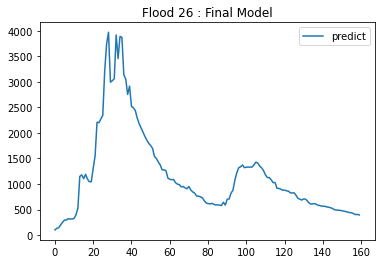

In [61]:
plt.figure(figsize = (15, 12))
pd.DataFrame(predict, columns = ['predict']).plot()
plt.title('Flood 26 : Final Model')
plt.show()

In [62]:
submit['유입량'] = predict

In [63]:
submit.head()

,홍수사상번호,연,월,일,시간,유입량
0,26.0,2018.0,7.0,1.0,6.0,100.350609
1,26.0,2018.0,7.0,1.0,7.0,131.075089
2,26.0,2018.0,7.0,1.0,8.0,144.463470
3,26.0,2018.0,7.0,1.0,9.0,197.632553
4,26.0,2018.0,7.0,1.0,10.0,252.031357


In [64]:
submit.to_excel('최종제출.xlsx', index = False)